## Генерация датасета
Добавлено распараллеливание.

Для ускорения лучше отключить fenics_adjoint, использовать только fenics (для этого закомментировать 'from fenics_adjoint import \*' в файлах elasticity_solver.py, subdomains.py, expressions.py; закомментировать Tape в elasticity_solver::init(). 

In [1]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull
from tqdm import tqdm

In [2]:
sys.path.append('/home/alex/10_term/Rheology reconstruction/RheologyReconstruction')

In [3]:
SEED = 1

LLIM_X = 0.0
RLIM_X = 2000.0

LLIM_Y = 0.0
RLIM_Y = 2000.0

In [4]:
def create_hull():

    cx = (LLIM_X + RLIM_X) / 2.
    cy = (LLIM_X + RLIM_X) / 2.

    disp_x = np.random.uniform(160., 200.)
    disp_y = np.random.uniform(disp_x / 2., disp_x * 0.66)

    # center of the shape
    base = np.array(
        [[a, b] for a, b in zip(
            np.ones(100) * cx + np.random.uniform(-200., 200.),
            np.ones(100) * cy + np.random.uniform(-200., 200.))]
    )

    # a random angle to rotate the polygon
    angle = np.pi * np.random.normal(0, 90) / 180

    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])


    data = np.random.normal(0, (disp_x, disp_y), (100, 2))
    data = data.dot(rotation_matrix) + base

    hull = ConvexHull(data)

    xx, yy = np.meshgrid(
        np.linspace(LLIM_X, RLIM_X, 128),
        np.linspace(LLIM_Y, RLIM_Y, 128)
    )

    res = []

    for x, y in zip(xx.flatten(), yy.flatten()):
        pts = np.concatenate((hull.points, np.array([[x, y]])))
        hull_tmp = ConvexHull(pts)
        if np.array_equal(hull.vertices,hull_tmp.vertices):
            res.append(1.)
        else:
            res.append(0.)

    return np.array(res).reshape(128, 128)

In [5]:
detector_coords = [(np.array([c, 2000.])) for c in np.linspace(0., 2000., 128)] 
buffer          = np.zeros((2, 128, 128))


def save(
    timestep, 
    curr_time,
    u_field, 
    v_field, 
    a_field
):
    
    data = [u_field(c) for c in detector_coords]
    buffer[:, timestep+1] = np.array(data).T

In [6]:
from pipeline.dolfin_adjoint.elasticity_solver import elasticity_solver

In [7]:
dataset_dir = os.path.join(os.getcwd(), 'dataset_parallel')
config_path = '/home/alex/10_term/Rheology reconstruction/RheologyReconstruction' +\
    '/datasets/heterogeneity/solver_config.yaml'

In [8]:
def run_simulations_consecutive(n_samples):
    start_time = time.time()
    
    np.random.seed(SEED)
    dataset_dir = os.path.join(os.getcwd(), 'dataset')
    config_path = '/home/alex/10_term/Rheology reconstruction/RheologyReconstruction' +\
                '/datasets/heterogeneity/solver_config.yaml'
    
    for i in tqdm(range(n_samples), desc='running'):

        hull = create_hull()
        np.save(os.path.join(dataset_dir, 'masks', f'{i}'), hull)

        slvr = elasticity_solver(
            hull.T,
            hull.T,
            hull.T,
            config_path
        )

        slvr.forward(save_callback=save)

        np.save(os.path.join(dataset_dir, 'seismograms', f'{i}'), buffer)

    finish_time = time.time()
    print('\nProgram took {:.2f} seconds.'.format(finish_time - start_time))

In [9]:
# run_simulations_consecutive(5)

# Parallel version

In [10]:
from multiprocessing import Process

In [11]:
def run_simulations_in_parallel(rank, size, NumberOfSimulations):
    np.random.seed(rank) # initializing seed = rank different for each process
    
    i = rank
    while i < NumberOfSimulations:
        hull = create_hull()
        np.save(os.path.join(dataset_dir, 'masks', f'{i}'), hull)

        slvr = elasticity_solver(hull.T, hull.T, hull.T, config_path)
        slvr.forward(save_callback=save)

        np.save(os.path.join(dataset_dir, 'seismograms', f'{i}'), buffer)
        
        i += size
    return

In [12]:
def run_parallel_simulations(np, NumberOfSimulations):
    processes = [Process(target=run_simulations_in_parallel,
                         args=(i, np, NumberOfSimulations)
                 ) for i in range(np)]
    
    for p in processes: p.start()
    for p in processes: p.join()

In [13]:
%%time
if __name__ == '__main__':
    run_parallel_simulations(np=6, NumberOfSimulations=5000)

CPU times: user 120 ms, sys: 111 ms, total: 231 ms
Wall time: 2h 31min 24s


In [14]:
print(dataset_dir)
print(config_path)

/home/alex/10_term/Rheology reconstruction/RheologyReconstruction/notebooks/dataset_parallel
/home/alex/10_term/Rheology reconstruction/RheologyReconstruction/datasets/heterogeneity/solver_config.yaml


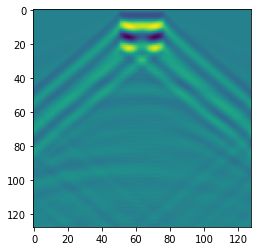

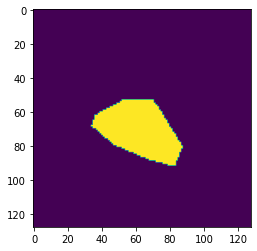

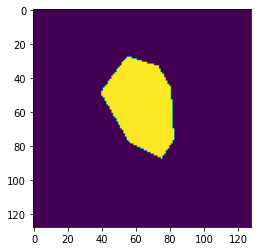

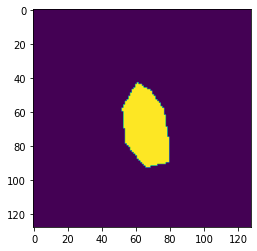

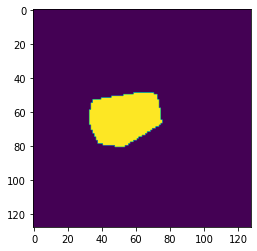

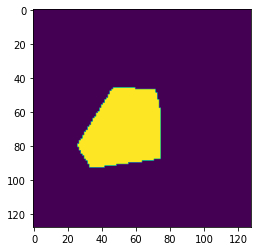

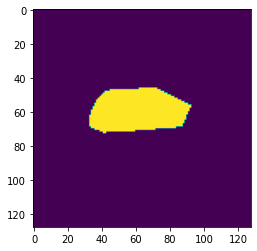

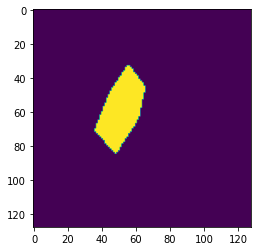

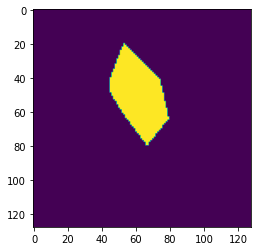

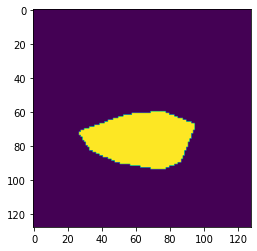

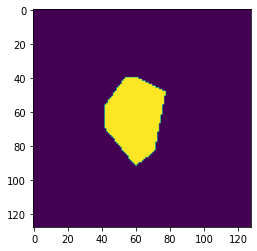

In [17]:
plt.imshow(np.load(dataset_dir + '/seismograms/34.npy')[1])
plt.show()

for i in range(25,35):
    plt.imshow(np.load(dataset_dir + '/masks/{}.npy'.format(i)))
    plt.show()